In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row):
    cs = row["index"].count("C")
    gs = row["index"].count("G")
    gc = (cs+gs)/len(row["index"])
    return gc

In [6]:
def calculate_cpg(row):
    cpgs = row["index"].count("CG")
    cpg = cpgs/len(row["index"])
    return cpg

In [7]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

In [8]:
def activ_or_repress(row):
    if row.beta > 0:
        return "activating"
    elif row.beta < 0:
        return "repressing"

## variables

In [9]:
data_f = "../../../data/02__mpra/02__activs/alpha_per_elem.quantification.txt"

In [10]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [11]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED_WITH_MAX.txt"

In [12]:
motif_dir = "../../../data/04__mapped_motifs/elem_fimo_out"
motifs_f = "%s/fimo.txt.gz" % motif_dir

In [13]:
elem_map_f = "../../../data/04__mapped_motifs/fastas/elem_map.txt"

In [14]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [15]:
hESC_tf_f = "../../../data/03__rna_seq/04__TF_expr/hESC_TF_expression.txt"
mESC_tf_f = "../../../data/03__rna_seq/04__TF_expr/mESC_TF_expression.txt"

## 1. import data

In [16]:
data = pd.read_table(data_f).reset_index()
data.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,7.295239,6.315911,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,1.326796,1.348824,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.977164,1.548916,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.976127,0.818171,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,1.323999,1.457128,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01


In [17]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [18]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har,tss_tile_num_max_hg19,tss_tile_num_max_mm9,n_tiles_hg19,n_tiles_mm9,tile_match
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0,6966.0,1361.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,0.0,960.0,123.0,human,False,tile1,tile1,1.0,1.0,tile1:tile1
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,0.0,753.0,770.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1


In [19]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
2,ZNF212,elem_10288,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
3,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
4,ZNF212,elem_10288,7,36,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA


In [20]:
elem_map = pd.read_table(elem_map_f, sep="\t")
elem_map.head()

,elem_key,elem
0,elem_1,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...
1,elem_2,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...
2,elem_3,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...
3,elem_4,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...
4,elem_5,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...


In [21]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [22]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [23]:
hESC_tf = pd.read_table(hESC_tf_f)
mESC_tf = pd.read_table(mESC_tf_f)
hESC_tf.head()

,index,gene_name,mean_tpm
0,ENSG00000188290,HES4,10.378615
1,ENSG00000197921,HES5,2.664051
2,ENSG00000142611,PRDM16,55.601719
3,ENSG00000078900,TP73,117.897387
4,ENSG00000173673,HES3,272.208698


## 2. calculate GC and CpG content per element

In [24]:
data["gc_content"] = data.apply(calculate_gc, axis=1)
data.sample(5)

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,gc_content
12063,TGCATCTCTAAGGCTAGCATCCGCGCCGCTCATAGACTCGATACCA...,1.184661,1.688827,2.589573e-01,5.337776e-02,5.081030e-01,1.807343e-01,0.513889
2581,ATCCCCCACTTTCTGTCTCCCAATAACAGTCCCTGTTCTAATTCCA...,2.312440,1.924428,4.642668e-05,1.305135e-02,1.903000e-04,5.230715e-02,0.534722
9062,GGCCGGCCTGGGCTCCTGCAGAGCAGATCCTGTCTGCGTCCTCCAG...,1.180327,0.959832,2.630313e-01,6.102086e-01,5.137364e-01,7.710105e-01,0.701389
13800,TGGATAGCGGTTTGACTCACGGGGATTTCCAAGTCTCCACCCCATT...,6.261261,5.915797,2.406150e-53,1.226828e-36,3.106508e-52,1.559262e-35,0.480263
4084,CCAGGGAGGAAGGCGGGGCGGGATGTGGGCGGGGCCGCGGGTGGGG...,1.152619,1.920986,2.898281e-01,1.335454e-02,5.465385e-01,5.333744e-02,0.694444


In [25]:
data["cpg_content"] = data.apply(calculate_cpg, axis=1)
data.sample(5)

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,gc_content,cpg_content
4551,CCCTTCCCGCCGCTGAGGATTTACTCGTCTCTTGGCAACCATTCAC...,3.184628,2.626431,6.327457e-11,0.000026,3.566969e-10,0.000144,0.708333,0.090278
455,AAGACCACCCAGAGTTCTGATCGGATGGAAGCCTCCGTCTAATTAG...,1.372952,1.809027,1.167924e-01,0.027112,2.801039e-01,0.100102,0.520833,0.048611
6377,CTGGAAGGGATAGATGACCCCAGCCGAGGCTACAGCCGCTGCCCCC...,1.169409,1.039780,2.734374e-01,0.528811,5.276015e-01,0.754607,0.645833,0.111111
13599,CCATTGACGTCAATGGGTGGAGTATTTACGGTAAACTGCCCACTTG...,0.809900,0.787962,6.690869e-01,0.766116,7.983198e-01,0.825923,0.460526,0.039474
7587,GATTTTCAAAGAAGATGCCCAGCTATGCTGCATCCTCATCCACACT...,0.752292,0.861596,7.270845e-01,0.703651,8.178424e-01,0.797127,0.583333,0.055556


In [26]:
data["HUES64_log"] = np.log10(data["HUES64"]+1)
data["mESC_log"] = np.log10(data["mESC"]+1)
data.sample(5)

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,gc_content,cpg_content,HUES64_log,mESC_log
10749,TAGAGTTGCGGTATTCATATATCGTTCAAGCACGAGTAGGGAACTG...,0.733687,0.723419,0.744677,0.814260,0.826252,0.850392,0.500000,0.076389,0.238971,0.236391
11471,TCGATGAGAAGGTGGACCCTACAGGCGCTTAGTAACTCAATGTGTC...,0.862906,0.830781,0.611825,0.730703,0.778610,0.809151,0.500000,0.041667,0.270191,0.262636
4627,CCGCCACTGCAACTTTGTGCAGCCGCGGCGCGCCGGCGGCGACCCT...,1.209225,0.925503,0.236498,0.643935,0.479386,0.780959,0.673611,0.125000,0.344240,0.284544
5447,CGGAAGGAATCTGAATTTGTTTTTGTTTCTGCTTTGGTTCGCCCCT...,2.585625,2.518709,0.000001,0.000082,0.000006,0.000442,0.472222,0.027778,0.554565,0.546383
1242,ACGCATATAGTGAATTTTTCCCATACCGTCCCAGACCGGACAAAGG...,1.610232,1.199504,0.030226,0.366011,0.087598,0.677303,0.520833,0.062500,0.416679,0.342325


In [27]:
data["avg_activ"] = data[["HUES64", "mESC"]].mean(axis=1)
data["avg_activ_log"] = np.log10(data["avg_activ"]+1)

In [28]:
data["HUES64_box"] = boxcox(data["HUES64"])[0]
data["mESC_box"] = boxcox(data["mESC"])[0]
data["avg_activ_box"] = boxcox(data["avg_activ"])[0]
data.sample(5)

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,gc_content,cpg_content,HUES64_log,mESC_log,avg_activ,avg_activ_log,HUES64_box,mESC_box,avg_activ_box
5575,CGGGCGTTTCCGGCCTTGGACTACATTTCCCACAGGCGCCCGGGCG...,5.761431,4.231143,3.938123e-44,1.069746e-16,4.414960e-43,9.279379e-16,0.625000,0.090278,0.830039,0.718597,4.996287,0.777882,1.113106,0.919871,0.936052
8001,GCCCTTGCACGGCGGCACAAGTCCAGAGGGGGCTGAGGAATACCCT...,1.625536,1.552079,2.731873e-02,1.042159e-01,8.010915e-02,3.100340e-01,0.673611,0.090278,0.419218,0.406894,1.588808,0.413100,0.425010,0.380081,0.391390
10990,TCAAGTGGGCGGTCACCGCCTTGGACGCAGTCGCCGTGCTGGCGCC...,1.275911,1.068867,1.812809e-01,4.987059e-01,3.953357e-01,7.440119e-01,0.722222,0.131944,0.357155,0.315733,1.172389,0.336938,0.227673,0.065117,0.149957
10474,TAAAAACGTCACCTCCGCCCACCAGCTAGCTCGGGACCAATCCACC...,6.464509,7.189606,2.377651e-57,3.401308e-57,3.203827e-56,5.476421e-56,0.652778,0.076389,0.873001,0.913263,6.827057,0.893599,1.154665,1.087150,1.019755
5863,CTATGTACAAGGACCCACGCCCCCGACACATTACAGGAGGTGGTTT...,0.636125,0.688379,8.263959e-01,8.376100e-01,8.651744e-01,8.657024e-01,0.458333,0.013889,0.213817,0.227470,0.662252,0.220697,-0.515240,-0.424999,-0.482604


In [29]:
data["short_elem"] = data["index"].str.split("__", expand=True)[0]
data.sample(5)

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,gc_content,cpg_content,HUES64_log,mESC_log,avg_activ,avg_activ_log,HUES64_box,mESC_box,avg_activ_box,short_elem
7623,GCAAGCTTGCACGGTGCCACCACGAGAAGCAGCGCAGCCCGGGTTG...,1.447847,1.074773,0.079595,0.492589,0.204045,0.741924,0.680556,0.083333,0.388784,0.316971,1.261310,0.354360,0.334039,0.070373,0.213132,GCAAGCTTGCACGGTGCCACCACGAGAAGCAGCGCAGCCCGGGTTG...
3249,CACCCCGGCTGCCACCCCGGCCGGGGCCGCGGCGCCCGCACCTCTC...,1.075294,1.618170,0.370612,0.076432,0.629501,0.242856,0.736111,0.125000,0.317080,0.417998,1.346732,0.370463,0.071130,0.410591,0.266899,CACCCCGGCTGCCACCCCGGCCGGGGCCGCGGCGCCCGCACCTCTC...
9503,GGGGCAGGCAGCTCTGAGGCAGCATGCAGTGGCTCCTGCCCCTGCT...,1.222742,1.164053,0.224612,0.401143,0.462109,0.702208,0.555556,0.013889,0.346889,0.335268,1.193397,0.341117,0.190121,0.144339,0.165624,GGGGCAGGCAGCTCTGAGGCAGCATGCAGTGGCTCCTGCCCCTGCT...
6153,CTCTCTCACTCTCTCACTCACTCTCTCTCTCTCTCTCTCTCTCTCA...,1.053082,0.862786,0.395125,0.702582,0.651636,0.796750,0.513889,0.027778,0.312406,0.270163,0.957934,0.291798,0.050975,-0.155234,-0.043674,CTCTCTCACTCTCTCACTCACTCTCTCTCTCTCTCTCTCTCTCTCA...
7910,GCCCAAGCTACAAGGAAAGGTCATATGTGGGTGCTTCAATTGACAG...,0.913631,1.160958,0.554628,0.404252,0.755507,0.702909,0.520833,0.000000,0.281858,0.334646,1.037295,0.309054,-0.092667,0.141936,0.036120,GCCCAAGCTACAAGGAAAGGTCATATGTGGGTGCTTCAATTGACAG...


## 3. build reduced model (CG + CpG content)

In [30]:
scaled_features = StandardScaler().fit_transform(data[["avg_activ_box", "gc_content", "cpg_content"]])
data_norm = pd.DataFrame(scaled_features, index=data.index, columns=["avg_activ_box", "gc_content", "cpg_content"])
data_norm["index"] = data['index']
data_norm["HUES64_padj"] = data["HUES64_padj"]
data_norm["mESC_padj"] = data["mESC_padj"]
data_norm["short_elem"] = data["short_elem"]
data_norm.head()

,avg_activ_box,gc_content,cpg_content,index,HUES64_padj,mESC_padj,short_elem
0,1.716174,-0.057813,0.277692,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,4.596852e-74,1.878236e-41,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...
1,-0.009080,-1.050424,-0.632888,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,3.319934e-01,5.455262e-01,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...
2,-0.116774,-1.579817,-1.179237,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,7.164347e-01,3.127558e-01,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...
3,-0.862370,-1.645991,-1.179237,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,7.167637e-01,8.145300e-01,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...
4,0.060781,-0.785728,-0.632888,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,3.356231e-01,4.172106e-01,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...


In [31]:
data_filt = data_norm[((data_norm["HUES64_padj"] < QUANT_ALPHA) | (data_norm["mESC_padj"] < QUANT_ALPHA))]
len(data_filt)

4808

In [32]:
avg_mod = smf.ols(formula='avg_activ_box ~ gc_content + cpg_content', 
                   data=data_norm).fit()

In [33]:
avg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_activ_box   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     1235.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:01:13   Log-Likelihood:                -18557.
No. Observations:               13879   AIC:                         3.712e+04
Df Residuals:                   13876   BIC:                         3.714e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.939e-17      0.008  -8.87e-15      1.000      -0.015       0.015
gc_content      0.1861      0.011     16.515      0.000       0.164       0.208
cpg_content     0.2326      0.011     20.634      0.000       0.210       0.255
==============================================================================
Omnibus:                      707.253   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2106.039
Skew:                          -0.227   Prob(JB):                         0.00
Kurtosis:                       4.854   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

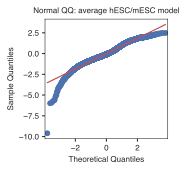

In [34]:
res = avg_mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: average hESC/mESC model")
fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [35]:
reduced_llf = avg_mod.llf
reduced_llf

-18556.945979591339

In [36]:
reduced_rsq = avg_mod.rsquared
reduced_rsq

0.15106519263047724

## 4. add individual motifs to the model

In [37]:
len(motifs)

4390808

In [38]:
# only analyze the "best" motifs as determined by lambert et al
best_motifs = motif_info[~pd.isnull(motif_info["Best Motif(s)? (Figure 2A)"])]
len(best_motifs)

1496

In [39]:
# only analyze the TFs that are expressed in hESCs or mESCs
hESC_expr = hESC_tf[hESC_tf["mean_tpm"] > 1]
mESC_expr = mESC_tf[mESC_tf["mean_tpm_mouse"] > 1]
print(len(hESC_expr))
print(len(mESC_expr))

1020
847


In [40]:
best_motifs = best_motifs[((best_motifs["HGNC symbol"].isin(hESC_expr["gene_name"])) |
                           (best_motifs["HGNC symbol"].isin(mESC_expr["gene_name_human"])))]
len(best_motifs)

1360

In [41]:
best_motifs["short_id"] = best_motifs["CIS-BP ID"].str.split(".", expand=True)[0]
mapped_best_motifs = motifs[motifs["#pattern name"].isin(best_motifs["short_id"])]
len(mapped_best_motifs)

1352562

In [42]:
uniq_motifs = list(best_motifs["short_id"].unique())
print(len(uniq_motifs))

1294


In [43]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_norm.copy()

    elem_ids_w_motif = list(mapped_best_motifs[mapped_best_motifs["#pattern name"] == motif_id]["sequence name"].unique())
    elems_w_motif = list(elem_map[elem_map["elem_key"].isin(elem_ids_w_motif)]["elem"])
    
    tmp["has_motif"] = tmp["short_elem"].isin(elems_w_motif)
    tmp["has_motif"] = tmp["has_motif"].astype(int)
    
    # build model with motif included
    motif_mod = smf.ols(formula='avg_activ_box ~ gc_content + cpg_content + has_motif', 
                        data=tmp).fit()
    
    # perform likelihood ratio test
    motif_llf = motif_mod.llf
    lr, p = lrtest(reduced_llf, motif_llf)
    
    # calculate additional variance explained
    rsq = motif_mod.rsquared - reduced_rsq
    
    # record beta
    beta = list(motif_mod.params)[-1]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(elems_w_motif), p, rsq))
    motif_results[motif_id] = {"lr_test": lr, "pval": p, "rsq": rsq, "beta": beta}

(#1) M03663_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#2) M06440_1: n w/ motif: 167 ... p: 0.602063733577, rsquared: 1.66307703805e-05
(#3) M08464_1: n w/ motif: 94 ... p: 0.0573823224863, rsquared: 0.000220873628243
(#4) M05586_1: n w/ motif: 106 ... p: 0.0445797250984, rsquared: 0.000246739871524
(#5) M05563_1: n w/ motif: 196 ... p: 0.00110908888107, rsquared: 0.00065031985346
(#6) M05564_1: n w/ motif: 246 ... p: 5.25864832355e-05, rsquared: 0.000999642598156
(#7) M09429_1: n w/ motif: 105 ... p: 0.0657742740355, rsquared: 0.000207052002108
(#8) M09430_1: n w/ motif: 103 ... p: 0.761582501891, rsquared: 5.63060983505e-06
(#9) M00142_1: n w/ motif: 196 ... p: 0.358911296142, rsquared: 5.14825236784e-05
(#10) M00140_1: n w/ motif: 131 ... p: 0.78382362761, rsquared: 4.603541922e-06
(#11) M00144_1: n w/ motif: 123 ... p: 0.00104914513168, rsquared: 0.000656602249996
(#12) M00146_1: n w/ motif: 109 ... p: 0.176750037763, rsquared: 0.000111606303671
(#13) M00143_1: n w/ motif: 100 ...

(#103) M00872_1: n w/ motif: 938 ... p: 0.0496723627861, rsquared: 0.000235611659794
(#104) M00881_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#105) M05613_1: n w/ motif: 98 ... p: 0.000194335406314, rsquared: 0.000848881807845
(#106) M01380_1: n w/ motif: 95 ... p: 0.709834718827, rsquared: 8.46802558407e-06
(#107) M01428_1: n w/ motif: 107 ... p: 0.061604453162, rsquared: 0.000213668965156
(#108) M06487_1: n w/ motif: 320 ... p: 0.316548278756, rsquared: 6.13576244337e-05
(#109) M03819_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#110) M03875_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#111) M03876_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#112) M08556_1: n w/ motif: 122 ... p: 0.19604343316, rsquared: 0.000102240786841
(#113) M08560_1: n w/ motif: 122 ... p: 0.19604343316, rsquared: 0.000102240786841
(#114) M05616_1: n w/ motif: 102 ... p: 0.466052904517, rsquared: 3.24984835181e-05
(#115) M05617_1: n w/ motif: 102 ... p: 0.466052904517, rsquared: 3.24984835181e-05
(#116) M08569_1:

(#205) M05719_1: n w/ motif: 339 ... p: 0.628306849216, rsquared: 1.43351757296e-05
(#206) M09581_1: n w/ motif: 168 ... p: 0.225307008521, rsquared: 8.9925515504e-05
(#207) M09582_1: n w/ motif: 278 ... p: 0.93596326525, rsquared: 3.94846587093e-07
(#208) M05721_1: n w/ motif: 232 ... p: 0.853586533683, rsquared: 2.08313092587e-06
(#209) M05723_1: n w/ motif: 232 ... p: 0.853586533683, rsquared: 2.08313092587e-06
(#210) M04026_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#211) M04027_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#212) M08675_1: n w/ motif: 318 ... p: 0.182738184981, rsquared: 0.000108577284295
(#213) M01048_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#214) M04169_1: n w/ motif: 292 ... p: 0.697427305632, rsquared: 9.24605844832e-06
(#215) M01022_1: n w/ motif: 211 ... p: 0.49896958229, rsquared: 2.79605823206e-05
(#216) M03020_1: n w/ motif: 235 ... p: 0.0791926005231, rsquared: 0.000188458293959
(#217) M08681_1: n w/ motif: 198 ... p: 0.127609411603, rsquared: 0.0001419

(#309) M08771_1: n w/ motif: 137 ... p: 0.00404735874029, rsquared: 0.000505237371677
(#310) M01414_1: n w/ motif: 129 ... p: 0.887413847326, rsquared: 1.22603677866e-06
(#311) M05792_1: n w/ motif: 119 ... p: 0.790450209017, rsquared: 4.31900078557e-06
(#312) M08773_1: n w/ motif: 158 ... p: 0.404620714008, rsquared: 4.24824392259e-05
(#313) M02159_1: n w/ motif: 132 ... p: 0.929652247936, rsquared: 4.76720741105e-07
(#314) M06580_1: n w/ motif: 185 ... p: 0.317846359656, rsquared: 6.10293570359e-05
(#315) M06581_1: n w/ motif: 88 ... p: 0.376824701466, rsquared: 4.77721290041e-05
(#316) M04182_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#317) M05793_1: n w/ motif: 120 ... p: 0.197438348541, rsquared: 0.000101605676591
(#318) M08775_1: n w/ motif: 186 ... p: 0.266099293871, rsquared: 7.56444345084e-05
(#319) M08779_1: n w/ motif: 151 ... p: 0.780970888513, rsquared: 4.72904364746e-06
(#320) M05795_1: n w/ motif: 174 ... p: 0.511158931113, rsquared: 2.64049502012e-05
(#321) M05796_1: n

(#409) M08872_1: n w/ motif: 3736 ... p: 2.83129967273e-91, rsquared: 0.0247422049277
(#410) M08876_1: n w/ motif: 3968 ... p: 2.20337230713e-79, rsquared: 0.0214923404895
(#411) M08874_1: n w/ motif: 3887 ... p: 8.0528589083e-75, rsquared: 0.0202422489154
(#412) M05868_1: n w/ motif: 3924 ... p: 7.13620621488e-86, rsquared: 0.0232674056546
(#413) M08878_1: n w/ motif: 3698 ... p: 1.35616692079e-71, rsquared: 0.0193573171653
(#414) M08880_1: n w/ motif: 2203 ... p: 0.20722715001, rsquared: 9.72921162457e-05
(#415) M08881_1: n w/ motif: 3331 ... p: 1.58258670346e-48, rsquared: 0.01300748981
(#416) M08883_1: n w/ motif: 2229 ... p: 1.4067821637e-25, rsquared: 0.00665826304807
(#417) M08884_1: n w/ motif: 3095 ... p: 3.86011608863e-34, rsquared: 0.00902938524331
(#418) M08886_1: n w/ motif: 3336 ... p: 4.74306043332e-43, rsquared: 0.0114944938903
(#419) M08888_1: n w/ motif: 2527 ... p: 6.79877968049e-34, rsquared: 0.00896132679315
(#420) M00600_1: n w/ motif: 3400 ... p: 6.0494448634e-97

(#509) M02087_1: n w/ motif: 361 ... p: 0.986768628545, rsquared: 1.68223081021e-08
(#510) M02088_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#511) M05934_1: n w/ motif: 316 ... p: 0.00240372714232, rsquared: 0.000563310603067
(#512) M08957_1: n w/ motif: 290 ... p: 3.72417639624e-07, rsquared: 0.0015786067424
(#513) M06660_1: n w/ motif: 191 ... p: 0.470603394723, rsquared: 3.18403508784e-05
(#514) M04472_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#515) M04476_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#516) M04432_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#517) M05935_1: n w/ motif: 503 ... p: 0.132321562566, rsquared: 0.000138534955827
(#518) M05936_1: n w/ motif: 368 ... p: 4.10580485545e-05, rsquared: 0.00102831578199
(#519) M05937_1: n w/ motif: 525 ... p: 0.151469595449, rsquared: 0.000125834643676
(#520) M08959_1: n w/ motif: 899 ... p: 0.00989741135904, rsquared: 0.000406861981032
(#521) M08961_1: n w/ motif: 590 ... p: 0.0429506747491, rsquared: 0.000250584569231
(#522) M

(#609) M09055_1: n w/ motif: 296 ... p: 0.00281599048009, rsquared: 0.000545617450467
(#610) M09053_1: n w/ motif: 314 ... p: 4.59910034832e-07, rsquared: 0.00155374608722
(#611) M06714_1: n w/ motif: 237 ... p: 0.882862911904, rsquared: 1.32789200302e-06
(#612) M06715_1: n w/ motif: 865 ... p: 4.39739157194e-77, rsquared: 0.0208623867982
(#613) M01230_1: n w/ motif: 186 ... p: 0.422744178763, rsquared: 3.93094350621e-05
(#614) M07575_1: n w/ motif: 227 ... p: 1.74273057854e-05, rsquared: 0.00112787740852
(#615) M05989_1: n w/ motif: 111 ... p: 0.0510404538952, rsquared: 0.000232826947591
(#616) M09058_1: n w/ motif: 109 ... p: 0.824182463815, rsquared: 3.01912864265e-06
(#617) M05994_1: n w/ motif: 211 ... p: 0.320885371068, rsquared: 6.02676680693e-05
(#618) M09070_1: n w/ motif: 245 ... p: 0.50592484282, rsquared: 2.70650668254e-05
(#619) M09068_1: n w/ motif: 196 ... p: 0.214335356705, rsquared: 9.43078798464e-05
(#620) M05995_1: n w/ motif: 242 ... p: 0.573911071046, rsquared: 1.9

(#711) M09123_1: n w/ motif: 123 ... p: 0.0111132699976, rsquared: 0.000394258143566
(#712) M09127_1: n w/ motif: 125 ... p: 0.10117981514, rsquared: 0.000164330109832
(#713) M09129_1: n w/ motif: 114 ... p: 0.0538692995603, rsquared: 0.000227311151871
(#714) M05532_1: n w/ motif: 559 ... p: 0.419671131993, rsquared: 3.98331232758e-05
(#715) M09131_1: n w/ motif: 122 ... p: 0.239970119395, rsquared: 8.44531285673e-05
(#716) M09133_1: n w/ motif: 89 ... p: 0.747221881311, rsquared: 6.35400843207e-06
(#717) M09135_1: n w/ motif: 87 ... p: 0.471901325038, rsquared: 3.16545067499e-05
(#718) M06764_1: n w/ motif: 1110 ... p: 0.833267328742, rsquared: 2.71064843638e-06
(#719) M06083_1: n w/ motif: 131 ... p: 0.334859380156, rsquared: 5.68841055194e-05
(#720) M10290_1: n w/ motif: 293 ... p: 0.0582975216379, rsquared: 0.000219265137329
(#721) M09137_1: n w/ motif: 141 ... p: 0.469906148619, rsquared: 3.19405277989e-05
(#722) M04716_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#723) M09141_1: n

(#809) M06179_1: n w/ motif: 419 ... p: 0.300895290079, rsquared: 6.54595965933e-05
(#810) M09221_1: n w/ motif: 379 ... p: 0.0772585124108, rsquared: 0.000190920052295
(#811) M06181_1: n w/ motif: 267 ... p: 0.506504940845, rsquared: 2.69913271496e-05
(#812) M06182_1: n w/ motif: 376 ... p: 0.152320308425, rsquared: 0.00012531301471
(#813) M06183_1: n w/ motif: 431 ... p: 0.108244827819, rsquared: 0.000157775104829
(#814) M06185_1: n w/ motif: 90 ... p: 0.724397594281, rsquared: 7.60411056988e-06
(#815) M01857_1: n w/ motif: 261 ... p: 0.0161506488355, rsquared: 0.000353862004022
(#816) M00880_1: n w/ motif: 516 ... p: 0.000588996390002, rsquared: 0.000722099965196
(#817) M06186_1: n w/ motif: 1743 ... p: 0.000238679726605, rsquared: 0.000825295223184
(#818) M06195_1: n w/ motif: 1213 ... p: 0.000139969857741, rsquared: 0.000886612168505
(#819) M10001_1: n w/ motif: 1334 ... p: 4.57879482902e-08, rsquared: 0.0018261511802
(#820) M10002_1: n w/ motif: 1742 ... p: 2.42570626277e-07, rsq

(#912) M10310_1: n w/ motif: 753 ... p: 0.440523586006, rsquared: 3.63884921283e-05
(#913) M09315_1: n w/ motif: 590 ... p: 0.995344896825, rsquared: 2.08209061103e-09
(#914) M10416_1: n w/ motif: 673 ... p: 2.92177491157e-35, rsquared: 0.00933969437618
(#915) M09317_1: n w/ motif: 496 ... p: 1.99682794563e-30, rsquared: 0.0080010346655
(#916) ZFP57: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#917) M10434_1: n w/ motif: 2460 ... p: 1.82124533399e-12, rsquared: 0.00303258440164
(#918) ZFP69: n w/ motif: 622 ... p: 0.0660935264824, rsquared: 0.000206563956583
(#919) ZFP69B: n w/ motif: 1606 ... p: 0.0816892233557, rsquared: 0.000185374597079
(#920) M10394_1: n w/ motif: 347 ... p: 0.687646454471, rsquared: 9.88726200535e-06
(#921) ZFP90: n w/ motif: 366 ... p: 0.106896249427, rsquared: 0.000158989429866
(#922) M04982_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#923) M04983_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#924) M06848_1: n w/ motif: 3365 ... p: 0.31016846067, rsquared: 6.2996974

(#1014) ZNF273: n w/ motif: 772 ... p: 0.926003240408, rsquared: 5.27605467537e-07
(#1015) M09345_1: n w/ motif: 403 ... p: 0.0914535765729, rsquared: 0.000174221993647
(#1016) ZNF274: n w/ motif: 374 ... p: 0.290966377118, rsquared: 6.82071436393e-05
(#1017) M09347_1: n w/ motif: 188 ... p: 0.119109083187, rsquared: 0.000148561115244
(#1018) ZNF28: n w/ motif: 3009 ... p: 0.28571457948, rsquared: 6.97093369934e-05
(#1019) M10358_1: n w/ motif: 312 ... p: 0.0251684917809, rsquared: 0.000306528576678
(#1020) M10446_1: n w/ motif: 4806 ... p: 4.72887775695e-33, rsquared: 0.00872811207302
(#1021) M09349_1: n w/ motif: 4095 ... p: 2.14365783123e-25, rsquared: 0.00660759486373
(#1022) M09351_1: n w/ motif: 1630 ... p: 0.195910517216, rsquared: 0.000102301580075
(#1023) ZNF283: n w/ motif: 4075 ... p: 0.0725776130508, rsquared: 0.000197163168132
(#1024) ZNF284: n w/ motif: 226 ... p: 0.0560779124625, rsquared: 0.000223213869506
(#1025) ZNF285: n w/ motif: 280 ... p: 0.794954856179, rsquared:

(#1112) ZNF486: n w/ motif: 1375 ... p: 0.00927582368948, rsquared: 0.000413933453517
(#1113) ZNF487: n w/ motif: 806 ... p: 0.00583305829105, rsquared: 0.000464812107396
(#1114) M10444_1: n w/ motif: 688 ... p: 0.0555592560008, rsquared: 0.000224160482859
(#1115) ZNF496: n w/ motif: 485 ... p: 0.42075586655, rsquared: 3.96476178843e-05
(#1116) M09375_1: n w/ motif: 679 ... p: 0.00880714896633, rsquared: 0.000419594019421
(#1117) M10404_1: n w/ motif: 759 ... p: 0.0113057427464, rsquared: 0.000392393488758
(#1118) ZNF506: n w/ motif: 1249 ... p: 0.0399408332032, rsquared: 0.000258109125747
(#1119) M10396_1: n w/ motif: 1252 ... p: 0.655859370739, rsquared: 1.21471902674e-05
(#1120) ZNF519: n w/ motif: 4634 ... p: 0.0527563024577, rsquared: 0.000229443897397
(#1121) M05005_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1122) M09377_1: n w/ motif: 824 ... p: 7.69671151007e-07, rsquared: 0.00149313278988
(#1123) ZNF525: n w/ motif: 151 ... p: 0.727058941403, rsquared: 7.45187877371e-06
(#11

(#1212) ZNF701: n w/ motif: 1228 ... p: 0.0475845891679, rsquared: 0.000240021336644
(#1213) M09387_1: n w/ motif: 1050 ... p: 0.000775537172634, rsquared: 0.000690835942597
(#1214) M05016_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1215) ZNF705G: n w/ motif: 380 ... p: 0.579362412019, rsquared: 1.8794320202e-05
(#1216) ZNF707: n w/ motif: 1738 ... p: 0.130914560502, rsquared: 0.000139548420031
(#1217) M10341_1: n w/ motif: 783 ... p: 0.896814574184, rsquared: 1.02873734709e-06
(#1218) ZNF708: n w/ motif: 878 ... p: 9.00816214436e-05, rsquared: 0.000937413316233
(#1219) M10438_1: n w/ motif: 2922 ... p: 9.29892656494e-05, rsquared: 0.000933746683496
(#1220) M06970_1: n w/ motif: 928 ... p: 0.722245825441, rsquared: 7.72846044295e-06
(#1221) M06251_1: n w/ motif: 360 ... p: 0.499697703281, rsquared: 2.78658405904e-05
(#1222) ZNF714: n w/ motif: 941 ... p: 0.876909965652, rsquared: 1.46740107465e-06
(#1223) M05018_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1224) ZNF730: n w/ motif: 10

In [44]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results.head()

,index,lr_test,pval,rsq,beta
0,HKR1,6.281798,0.012198,0.000384,0.048118
1,M00140_1,0.075262,0.783824,0.000005,-0.022362
2,M00142_1,0.841699,0.358911,0.000051,-0.061472
3,M00143_1,0.102120,0.749301,0.000006,-0.029583
4,M00144_1,10.738762,0.001049,0.000657,-0.275327


In [45]:
motif_results["padj"] = multicomp.multipletests(motif_results["pval"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

448

## 5. merge motifs w/ TF info

In [46]:
all_motif_results = motif_results.merge(best_motifs[["short_id", "HGNC symbol"]], left_on="index", right_on="short_id")
all_motif_results.sample(5)

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol
757,M08929_1,7.804847e+00,0.005211,0.000477,0.126257,0.017885,M08929_1,MLX
100,M01749_1,-7.275958e-12,1.000000,0.000000,0.000000,1.000000,M01749_1,MSANTD3
1224,ZNF324B,1.931173e+00,0.164630,0.000118,-0.049582,0.310089,ZNF324B,ZNF324B
1208,ZNF267,4.808976e+00,0.028312,0.000294,0.045206,0.074311,ZNF267,ZNF267
1060,M10313_1,8.416908e+00,0.003717,0.000515,-0.155360,0.013288,M10313_1,ZKSCAN7


In [47]:
all_motif_results["activ_or_repr"] = all_motif_results.apply(activ_or_repress, axis=1)
all_motif_results.sample(5)

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr
287,M05611_1,5.066090e-01,0.476610,3.098712e-05,-0.079846,0.678475,M05611_1,CUX2,repressing
177,M04175_1,-7.275958e-12,1.000000,0.000000e+00,0.000000,1.000000,M04175_1,NPAS3,None
535,M06487_1,1.003155e+00,0.316548,6.135762e-05,0.052192,0.507143,M06487_1,DDIT3,activating
1230,ZNF33B,4.782109e-06,0.998255,2.925069e-10,0.000123,1.000000,ZNF33B,ZNF33B,activating
788,M08991_1,1.051639e+01,0.001183,6.430106e-04,-0.182544,0.004668,M08991_1,NR1D2,repressing


In [48]:
sig_motif_results = all_motif_results[all_motif_results["padj"] < 0.05]
len(sig_motif_results)

466

In [49]:
sig_motif_results.sort_values(by="rsq", ascending=False).head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr
1035,M10260_1,907.411028,2.403033e-199,0.053728,0.899031,3.109524e-196,M10260_1,GABPA,activating
306,M05660_1,860.055636,4.736579e-189,0.051010,0.917993,3.064567e-186,M05660_1,ELK4,activating
57,M00977_1,827.369873,6.046188e-182,0.049129,0.877262,2.607922e-179,M00977_1,ETV3L,activating
316,M05695_1,814.325975,4.143530e-179,0.048377,0.927295,1.340432e-176,M05695_1,ETV1,activating
652,M08655_1,811.032893,2.154428e-178,0.048187,0.872645,5.575659e-176,M08655_1,ETV4,activating


In [50]:
sig_motif_results.activ_or_repr.value_counts()

activating    281
repressing    185
Name: activ_or_repr, dtype: int64

## 6. plot results

In [51]:
over_1p = sig_motif_results[sig_motif_results["rsq"] >= 0.001].sort_values(by="rsq", ascending=False)
len(over_1p)

241

In [52]:
over_1p.activ_or_repr.value_counts()

activating    186
repressing     55
Name: activ_or_repr, dtype: int64

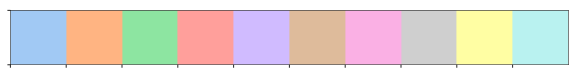

In [53]:
sns.palplot(sns.color_palette("pastel"))

In [54]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [55]:
full_pal = {}
for i, row in over_1p.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

83
83
83


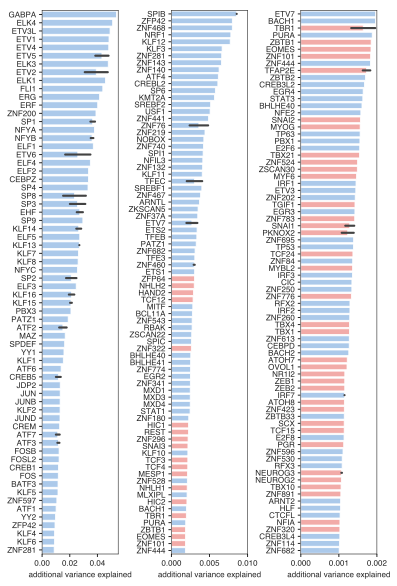

In [56]:
fig, axarr = plt.subplots(figsize=(6, 10), nrows=1, ncols=3)

ax = axarr[0]
sub = over_1p.head(83)
print(len(sub))
sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("additional variance explained")
ax.set_xlim((0, 0.055))

ax = axarr[1]
sub = over_1p.head(166).tail(83)
print(len(sub))
sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("additional variance explained")
ax.set_xlim((0, 0.01))

ax = axarr[2]
sub = over_1p.tail(83)
print(len(sub))
sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax)
ax.set_ylabel("")
ax.set_xlabel("additional variance explained")
ax.set_xlim((0, 0.002))

plt.subplots_adjust(wspace=0.7)
# fig.savefig("sig_motifs.pdf", dpi="figure", bbox_inches="tight")

## 7. merge elements with metadata (tss_id, biotype)

In [57]:
motifs_merged = mapped_best_motifs.merge(elem_map, left_on="sequence name", right_on="elem_key")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,elem_key,elem
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...
2,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...
3,ZNF212,elem_7205,7,36,+,51.4646,2.220000e-17,3.870000e-13,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGC,elem_7205,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...
4,ZNF212,elem_7205,9,38,+,34.2222,1.760000e-12,1.410000e-08,GAGAGAGAGAGAGAGAGAGAGAGAGAGCCT,elem_7205,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...


In [58]:
motifs_merged = motifs_merged.merge(index_elem, left_on="elem", right_on="element")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,element,tile_type,element_id,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,...,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...,WILDTYPE,"MOUSE_EVO_TSS__m.2482__tile2:9214553-9214697,-...",MOUSE_EVO_TSS__m.2482__tile2,1.0,chr4,-,9214553,9214697,11688.1.0.0
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,...,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...,WILDTYPE,"MOUSE_EVO_TSS__m.2482__tile2:9214553-9214697,-...",MOUSE_EVO_TSS__m.2482__tile2,1.0,chr4,-,9214553,9214697,11688.1.0.0
2,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA,elem_7205,...,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...,WILDTYPE,"MOUSE_EVO_TSS__m.2482__tile2:9214553-9214697,-...",MOUSE_EVO_TSS__m.2482__tile2,1.0,chr4,-,9214553,9214697,11688.1.0.0
3,ZNF212,elem_7205,7,36,+,51.4646,2.220000e-17,3.870000e-13,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGC,elem_7205,...,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...,WILDTYPE,"MOUSE_EVO_TSS__m.2482__tile2:9214553-9214697,-...",MOUSE_EVO_TSS__m.2482__tile2,1.0,chr4,-,9214553,9214697,11688.1.0.0
4,ZNF212,elem_7205,9,38,+,34.2222,1.760000e-12,1.410000e-08,GAGAGAGAGAGAGAGAGAGAGAGAGAGCCT,elem_7205,...,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGCCTCGCAGCAG...,WILDTYPE,"MOUSE_EVO_TSS__m.2482__tile2:9214553-9214697,-...",MOUSE_EVO_TSS__m.2482__tile2,1.0,chr4,-,9214553,9214697,11688.1.0.0


In [59]:
motifs_merged["tss_id"] = motifs_merged["name"].str.split("__", expand=True)[1]
motifs_merged["species"] = motifs_merged["name"].str.split("_", expand=True)[0]
motifs_merged["tss_tile_num"] = motifs_merged["name"].str.split("__", expand=True)[2]
motifs_merged.sample(5)

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info,tss_id,species,tss_tile_num
690854,ZNF730,elem_8765,119,127,-,11.24770,0.000097,0.29700,TGGCAGCTA,elem_8765,...,HUMAN_EVO_TSS__h.1067__tile1,1.0,chr5,+,72794153,72794297,5587.1.0.0,h.1067,HUMAN,tile1
410453,M06743_1,elem_9148,55,71,+,10.81190,0.000075,0.03560,CCCAGCCCACCCCCTTC,elem_9148,...,MOUSE_EVO_TSS__m.2959__tile2,1.0,chr5,+,123588400,123588544,12429.1.0.0,m.2959,MOUSE,tile2
946977,ZNF180,elem_5874,83,103,-,9.23853,0.000056,0.00614,CCTTTCTCGGCCCCTCCCTCC,elem_5874,...,MOUSE_EVO_TSS__m.3347__tile2,1.0,chr14,+,71034432,71034576,9411.1.0.0,m.3347,MOUSE,tile2
699870,M08884_1,elem_12842,120,130,+,11.88780,0.000040,0.04900,GGCCACTCCCA,elem_12842,...,MOUSE_EVO_TSS__m.1086__tile2,1.0,chr15,-,85506504,85506648,9692.1.0.0,m.1086,MOUSE,tile2
748109,M06048_1,elem_11433,63,78,-,15.57140,0.000002,0.04080,GGTTGCTATGGCCACG,elem_11433,...,MOUSE_EVO_TSS__m.51__tile1,1.0,chr5,-,120881740,120881884,12400.1.0.0,m.51,MOUSE,tile1


In [60]:
human_df = motifs_merged[(motifs_merged["species"] == "HUMAN") | (motifs_merged["name"] == "random_sequence")]
mouse_df = motifs_merged[(motifs_merged["species"] == "MOUSE") | (motifs_merged["name"] == "random_sequence")]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", "minimal_biotype_hg19", 
                                   "stem_exp_hg19", "orig_species", "mm9_id", "tile_match"]], 
                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", "minimal_biotype_mm9", 
                                   "stem_exp_mm9", "orig_species", "hg19_id", "tile_match"]], 
                          left_on="tss_id", right_on="mm9_id", how="left")
mouse_df.sample(5)

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species,hg19_id,tile_match
634584,ZNF266,elem_6130,74,88,+,9.89899,0.000084,0.4140,ACCAAACACAGCCCC,elem_6130,...,m.1107,MOUSE,tile1,m.1107,enhancer,eRNA,0.0,human,h.1235,tile2:tile2
537132,M08881_1,elem_10688,111,121,-,10.95920,0.000075,0.0520,ATCCACACCCT,elem_10688,...,m.1364,MOUSE,tile1,m.1364,no cage activity,lncRNA,no cage activity,human,h.1552,tile1:tile1
669145,M10379_1,elem_3350,23,33,+,14.23470,0.000011,0.0616,AGAGGCCGAGG,elem_3350,...,None,random,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488043,M10324_1,elem_7372,62,76,-,10.02750,0.000057,0.0910,CCACCCCGGGCAGCG,elem_7372,...,m.3158,MOUSE,tile1,m.3158,protein_coding,mRNA,4.42125,mouse,h.3348,tile1:tile1
410354,ZNF81,elem_3457,9,26,+,11.02860,0.000032,0.9160,TGTTCACACCAGGAAGGA,elem_3457,...,m.3261,MOUSE,tile2,m.3261,enhancer,eRNA,0.0469749,mouse,h.3451,tile1:tile1


In [61]:
mouse_df.columns

Index(['#pattern name', 'sequence name', 'start', 'stop', 'strand_x', 'score',
       'p-value', 'q-value', 'matched sequence', 'elem_key', 'elem', 'element',
       'tile_type', 'element_id', 'name', 'tile_number', 'chrom', 'strand_y',
       'actual_start', 'actual_end', 'dupe_info', 'tss_id', 'species',
       'tss_tile_num', 'mm9_id', 'biotype_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'orig_species', 'hg19_id', 'tile_match'],
      dtype='object')

## 8. find enrichment of motifs across biotypes

In [62]:
both_tile_ids = tss_map[(~pd.isnull(tss_map["n_tiles_hg19"]) & ~(pd.isnull(tss_map["n_tiles_mm9"])))]
len(both_tile_ids)

3312

In [63]:
tile1_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile1:tile1") | 
                          (both_tile_ids["tile_match"] == "tile1:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile1_ids)

2693

In [64]:
tile2_ids = both_tile_ids[(both_tile_ids["tile_match"] == "tile2:tile2")][["hg19_id", "mm9_id"]].drop_duplicates()
len(tile2_ids)

598

In [81]:
# limit dfs to tile1s where appropriate and tile2 where appropriate
human_tile1 = human_df.merge(tile1_ids, on=["hg19_id", "mm9_id"])
human_tile1 = human_tile1[human_tile1["tss_tile_num"] == "tile1"]
human_tile1 = human_tile1.drop(["orig_species", "mm9_id", "tile_match"], axis=1).drop_duplicates()
len(human_tile1)

290936

In [82]:
human_tile2 = human_df.merge(tile2_ids, on=["hg19_id", "mm9_id"])
human_tile2 = human_tile2[human_tile2["tss_tile_num"] == "tile2"]
human_tile2 = human_tile2.drop(["orig_species", "mm9_id", "tile_match"], axis=1).drop_duplicates()
len(human_tile2)

72087

In [83]:
mouse_tile1 = mouse_df.merge(tile1_ids, on=["mm9_id", "hg19_id"])
mouse_tile1 = mouse_tile1[mouse_tile1["tss_tile_num"] == "tile1"]
mouse_tile1 = mouse_tile1.drop(["orig_species", "hg19_id", "tile_match"], axis=1).drop_duplicates()
len(mouse_tile1)

274745

In [84]:
mouse_tile2 = mouse_df.merge(tile2_ids, on=["mm9_id", "hg19_id"])
mouse_tile2 = mouse_tile2[mouse_tile2["tss_tile_num"] == "tile2"]
mouse_tile2 = mouse_tile2.drop(["orig_species", "hg19_id", "tile_match"], axis=1).drop_duplicates()
len(mouse_tile2)

63305

In [85]:
print(len(human_tile1.hg19_id.unique()))
print(len(mouse_tile1.mm9_id.unique()))

2427
2394


In [86]:
print(len(human_tile2.hg19_id.unique()))
print(len(mouse_tile2.mm9_id.unique()))

595
583


In [87]:
human_df = human_tile1.append(human_tile2)
mouse_df = mouse_tile1.append(mouse_tile2)

In [88]:
biotype_motif_res = {}

for i, row in sig_motif_results.iterrows():
    motif_id = row["index"]
    print("(#%s: %s)" % (i+1, motif_id))
    
    human_motifs_sub = human_df[(human_df["#pattern name"] == motif_id)]["hg19_id"].unique()
    mouse_motifs_sub = mouse_df[(mouse_df["#pattern name"] == motif_id)]["mm9_id"].unique()
    
    tmp = {}
    for biotype in ["no CAGE activity", "eRNA", "lncRNA", "mRNA"]:
        
        # group no CAGE + reclassified together here
        if biotype == "no CAGE activity":
            human_sub = tss_map[tss_map["minimal_biotype_hg19"].isin(["no CAGE activity", 
                                                                        "reclassified - CAGE peak"])]["hg19_id"].unique()
            mouse_sub = tss_map[tss_map["minimal_biotype_mm9"].isin(["no CAGE activity", 
                                                                       "reclassified - CAGE peak"])]["mm9_id"].unique()
            
            human_not_sub = tss_map[~tss_map["minimal_biotype_hg19"].isin(["no CAGE activity", 
                                                                             "reclassified - CAGE peak"])]["hg19_id"].unique()
            mouse_not_sub = tss_map[~tss_map["minimal_biotype_mm9"].isin(["no CAGE activity", 
                                                                            "reclassified - CAGE peak"])]["mm9_id"].unique()
        else:
            human_sub = tss_map[tss_map["minimal_biotype_hg19"] == biotype]["hg19_id"].unique()
            mouse_sub = tss_map[tss_map["minimal_biotype_mm9"] == biotype]["mm9_id"].unique()
            
            human_not_sub = tss_map[tss_map["minimal_biotype_hg19"] != biotype]["hg19_id"].unique()
            mouse_not_sub = tss_map[tss_map["minimal_biotype_mm9"] != biotype]["mm9_id"].unique()
    
        # count occurrences of biotypes w/ and w/o motifs
        n_human_biotype_w_motif = len([x for x in human_sub if x in human_motifs_sub])
        n_human_not_biotype_w_motif = len([x for x in human_not_sub if x in human_motifs_sub])
        n_mouse_biotype_w_motif = len([x for x in mouse_sub if x in mouse_motifs_sub])
        n_mouse_not_biotype_w_motif = len([x for x in mouse_not_sub if x in mouse_motifs_sub])

        n_human_biotype_wo_motif = len([x for x in human_sub if x not in human_motifs_sub])
        n_human_not_biotype_wo_motif = len([x for x in human_not_sub if x not in human_motifs_sub])
        n_mouse_biotype_wo_motif = len([x for x in mouse_sub if x not in mouse_motifs_sub])
        n_mouse_not_biotype_wo_motif = len([x for x in mouse_not_sub if x not in mouse_motifs_sub])

        # hypergeometric test - combined
        tot_biotype_w_motif = n_human_biotype_w_motif + n_mouse_biotype_w_motif
        tot_biotype = n_human_biotype_w_motif + n_human_biotype_wo_motif + n_mouse_biotype_w_motif + n_mouse_biotype_wo_motif
        tot_motif = tot_biotype_w_motif + n_human_not_biotype_w_motif + n_mouse_not_biotype_w_motif
        tot = tot_biotype + n_human_not_biotype_w_motif + n_human_not_biotype_wo_motif + n_mouse_not_biotype_w_motif + n_mouse_not_biotype_wo_motif

        both_pval = stats.hypergeom.sf(tot_biotype_w_motif-1, tot, tot_biotype, tot_motif)

        # note results
        if biotype == "no CAGE activity":
            s = "no_CAGE"
        else:
            s = biotype
        tmp["%s_pval" % s] = both_pval
        
    biotype_motif_res[motif_id] = tmp
    

(#1: HKR1)
(#6: M00144_1)
(#10: M00224_1)
(#11: M00226_1)
(#14: M00242_1)
(#15: M00242_1)
(#16: M00255_1)
(#18: M00261_1)
(#19: M00267_1)
(#21: M00402_1)
(#22: M00404_1)
(#23: M00424_1)
(#25: M00554_1)
(#31: M00592_1)
(#32: M00600_1)
(#33: M00608_1)
(#34: M00610_1)
(#35: M00616_1)
(#37: M00636_1)
(#50: M00878_1)
(#52: M00880_1)
(#58: M00977_1)
(#62: M01021_1)
(#63: M01021_1)
(#75: M01232_1)
(#94: M01425_1)
(#96: M01433_1)
(#97: M01445_1)
(#103: M01775_1)
(#105: M01857_1)
(#115: M02098_1)
(#119: M02158_1)
(#125: M02208_1)
(#134: M02696_1)
(#135: M02702_1)
(#139: M03012_1)
(#141: M03040_1)
(#188: M04345_1)
(#216: M04818_1)
(#256: M05292_1)
(#257: M05322_1)
(#258: M05322_1)
(#260: M05451_1)
(#261: M05474_1)
(#262: M05480_1)
(#263: M05518_1)
(#265: M05548_1)
(#266: M05548_1)
(#267: M05548_1)
(#268: M05563_1)
(#269: M05564_1)
(#270: M05565_1)
(#271: M05568_1)
(#274: M05580_1)
(#276: M05584_1)
(#284: M05596_1)
(#289: M05613_1)
(#300: M05640_1)
(#301: M05643_1)
(#302: M05644_1)
(#303: M05647_

In [89]:
biotype_res = pd.DataFrame.from_dict(biotype_motif_res, orient="index").reset_index()
biotype_res.head()

,index,no_CAGE_pval,eRNA_pval,lncRNA_pval,mRNA_pval
0,HKR1,9.999998e-01,0.999539,0.041412,0.014142
1,M00144_1,5.919236e-07,0.544092,0.977764,0.995839
2,M00224_1,1.714611e-03,0.054279,0.953340,0.999992
3,M00226_1,9.871872e-01,0.126514,0.010007,0.694500
4,M00242_1,1.506064e-01,0.002871,0.978921,0.993408


In [90]:
biotype_melt = pd.melt(biotype_res, id_vars="index")
biotype_melt.head()

,index,variable,value
0,HKR1,no_CAGE_pval,9.999998e-01
1,M00144_1,no_CAGE_pval,5.919236e-07
2,M00224_1,no_CAGE_pval,1.714611e-03
3,M00226_1,no_CAGE_pval,9.871872e-01
4,M00242_1,no_CAGE_pval,1.506064e-01


In [91]:
biotype_melt["padj"] = multicomp.multipletests(biotype_melt["value"], method="fdr_bh")[1]
len(biotype_melt[biotype_melt["padj"] < 0.05])

330

In [92]:
biotype_melt.sample(5)

,index,variable,value,padj
583,M06208_1,eRNA_pval,0.000442,0.004040
1675,M10002_1,mRNA_pval,0.092556,0.313536
1581,M08951_1,mRNA_pval,0.997819,1.000000
44,M05563_1,no_CAGE_pval,0.458045,1.000000
824,M10410_1,eRNA_pval,0.004598,0.028024


In [93]:
def is_sig(row):
    if row["padj"] < 0.05:
        return 1
    else:
        return 0

In [94]:
biotype_melt["sig"] = biotype_melt.apply(is_sig, axis=1)
biotype_melt.head()

,index,variable,value,padj,sig
0,HKR1,no_CAGE_pval,9.999998e-01,1.000000,0
1,M00144_1,no_CAGE_pval,5.919236e-07,0.000012,1
2,M00224_1,no_CAGE_pval,1.714611e-03,0.012697,1
3,M00226_1,no_CAGE_pval,9.871872e-01,1.000000,0
4,M00242_1,no_CAGE_pval,1.506064e-01,0.455121,0


In [95]:
biotype_res = biotype_melt.pivot(index="index", columns="variable")["padj"]
biotype_res.head()

variable,eRNA_pval,lncRNA_pval,mRNA_pval,no_CAGE_pval
index,,,,
HKR1,1.000000,0.167517,0.070789,1.000000
M00144_1,1.000000,1.000000,1.000000,0.000012
M00224_1,0.209179,1.000000,1.000000,0.012697
M00226_1,0.398440,0.053211,1.000000,1.000000
M00242_1,0.018701,1.000000,1.000000,0.455121


In [96]:
def no_cage_vars(row):
    if row["no_CAGE_pval"] < 0.05:
        return 0
    else:
        return np.nan
    
def erna_vars(row):
    if row["eRNA_pval"] < 0.05:
        return 1
    else:
        return np.nan
    
def lncrna_vars(row):
    if row["lncRNA_pval"] < 0.05:
        return 2
    else:
        return np.nan
    
def mrna_vars(row):
    if row["mRNA_pval"] < 0.05:
        return 3
    else:
        return np.nan
    
biotype_res["no_CAGE_enr"] = biotype_res.apply(no_cage_vars, axis=1)
biotype_res["eRNA_enr"] = biotype_res.apply(erna_vars, axis=1)
biotype_res["lncRNA_enr"] = biotype_res.apply(lncrna_vars, axis=1)
biotype_res["mRNA_enr"] = biotype_res.apply(mrna_vars, axis=1)
biotype_res = biotype_res.reset_index()

In [97]:
biotype_res.head()

variable,index,eRNA_pval,lncRNA_pval,mRNA_pval,no_CAGE_pval,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,1.000000,0.167517,0.070789,1.000000,NaN,NaN,NaN,NaN
1,M00144_1,1.000000,1.000000,1.000000,0.000012,0.0,NaN,NaN,NaN
2,M00224_1,0.209179,1.000000,1.000000,0.012697,0.0,NaN,NaN,NaN
3,M00226_1,0.398440,0.053211,1.000000,1.000000,NaN,NaN,NaN,NaN
4,M00242_1,0.018701,1.000000,1.000000,0.455121,NaN,1.0,NaN,NaN


In [98]:
biotype_melt = pd.melt(biotype_res, id_vars="index", value_vars=["no_CAGE_enr", "eRNA_enr", "lncRNA_enr", "mRNA_enr"])
biotype_melt.head()

,index,variable,value
0,HKR1,no_CAGE_enr,NaN
1,M00144_1,no_CAGE_enr,0.0
2,M00224_1,no_CAGE_enr,0.0
3,M00226_1,no_CAGE_enr,NaN
4,M00242_1,no_CAGE_enr,NaN


In [99]:
sub.head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr
961,M09549_1,32.176501,1.407832e-08,0.001966,0.271451,1.175313e-07,M09549_1,ETV7,activating
583,M06885_1,32.119897,1.449452e-08,0.001962,0.245771,1.202302e-07,M06885_1,BACH1,activating
476,M06148_1,31.991928,1.548145e-08,0.001955,-0.312940,1.275987e-07,M06148_1,TBR1,repressing
559,M06743_1,30.716177,2.986646e-08,0.001877,0.107930,2.446025e-07,M06743_1,PURA,activating
32,M00608_1,30.266673,3.765405e-08,0.001849,-0.222514,3.064424e-07,M00608_1,ZBTB1,repressing


In [100]:
all_tfs = over_1p["HGNC symbol"].unique()
print(len(all_tfs))
all_tfs[0:5]

208


array(['GABPA', 'ELK4', 'ETV3L', 'ETV1', 'ETV4'], dtype=object)

In [101]:
all_tfs1 = all_tfs[0:72]
all_tfs2 = all_tfs[72:144]
all_tfs3 = all_tfs[144:]
print(len(all_tfs1))
print(len(all_tfs2))
print(len(all_tfs3))

72
72
64


93


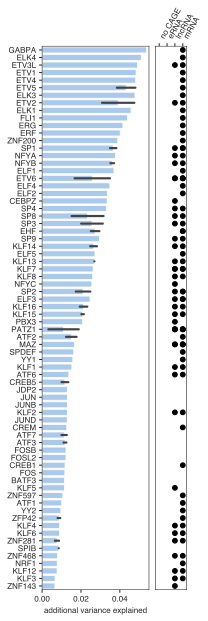

80


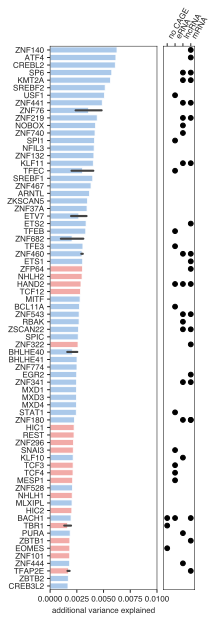

68


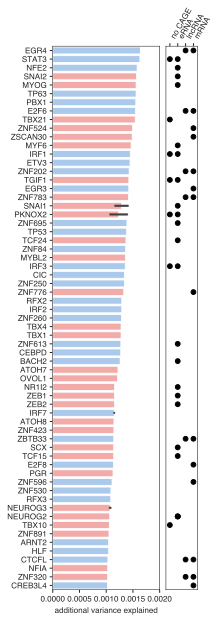

In [102]:
for tfs, xlims, pt in zip([all_tfs1, all_tfs2, all_tfs3],
                          [(0, 0.055), (0, 0.01), (0, 0.002)],
                          ["1", "2", "3"]):
    sub = over_1p[over_1p["HGNC symbol"].isin(tfs)]
    
    fig = plt.figure(figsize=(8, 10))

    ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 12), (0, 3), colspan=1, sharey=ax1)

    yvals = []
    symbs = []
    c = 0
    for i, row in sub.iterrows():
        symb = row["HGNC symbol"]
        if symb not in symbs:
            yvals.append(c)
            symbs.append(symb)
            c += 1
        else:
            yvals.append(c)

    sub["yval"] = yvals
    print(len(sub))
    sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax1)
    ax1.set_ylabel("")
    ax1.set_xlabel("additional variance explained")
    ax1.set_xlim(xlims)

    mrg = sub.merge(biotype_melt, on="index", how="left")
    mrg = mrg[["yval", "HGNC symbol", "variable", "value"]]
    ax2.plot(mrg["value"], mrg["yval"], 'o', color="black")
    ax2.set_xlim((-0.5, 3.5))
    ax2.set_ylim((np.max(yvals)-0.5, -0.5))
    ax2.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
    ax2.xaxis.set_ticks([0, 1, 2, 3])
    ax2.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")
    
    plt.show()
    fig.savefig("motif_var_and_enr.part%s.pdf" % (pt), dpi="figure", bbox_inches="tight")
    plt.close()

## 7. write file

In [103]:
len(all_motif_results)

1360

In [104]:
all_motif_results = all_motif_results.merge(biotype_res[["index", "no_CAGE_enr", "eRNA_enr", "lncRNA_enr",
                                                         "mRNA_enr"]], on="index")
all_motif_results.head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.036709,HKR1,HKR1,activating,NaN,NaN,NaN,NaN
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004203,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.009926,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027122,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000094,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [105]:
all_motif_results.to_csv("../../../data/04__mapped_motifs/sig_motifs.txt", sep="\t", index=False)